# 1. Data Collection using Web scraping

In [1]:
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from gensim.models import ldamodel
import gensim.corpora
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
import re
from nltk import pos_tag,word_tokenize

In [2]:
target_urls = ['https://www.capgemini.com/us-en/service/perform-ai/',
              'https://www.capgemini.com/us-en/service/applied-innovation-exchange/',
              'https://www.wipro.com/en-US/analytics/',
              'https://www.wipro.com/en-US/holmes/',
              'https://www.wipro.com/en-US/forms/accelerate-digital-journey-through-ethical-and-unbiased-ai/',
              'https://sites.tcs.com/bts/automation-ai/',
              'https://analyticsindiamag.com/tcs-ignio-infosys-nia-wipro-holmes-automation-platforms-india/',
              'https://www.dqindia.com/artificial-intelligence-trends-2019-hcl-technologies/',
              'https://careers.cognizant.com/na/en/c/consulting-jobs']

In [3]:
def extract(target_url):
    html = urlopen(target_url)
    soup = BeautifulSoup(html.read(), 'lxml')
    paragraphs = soup.find_all('p')
    headers = soup.find_all('h2')
    txt = []
    for x in paragraphs:
        txt.append(x.text)
    scraped_text = '. '.join(txt)
    return scraped_text

In [4]:
data_warehouse = []
for i in target_urls[-2:]:
    data_warehouse.append(extract(i))

# 2. Data Cleaning using NLP

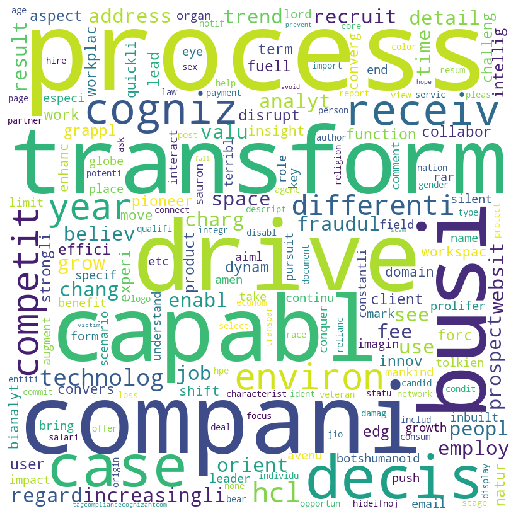

In [33]:
def preprocess(x):
    st  = stopwords.words('english')
    st = [str(i) for i in st] + ['ai','business','technology','use','see','year','busi','capable']
    ps = PorterStemmer()
    x = re.sub('[^A-z\s]+|the','',str(x))
    x = ' '.join([ps.stem(word) for word in x.split() if word.strip().lower() not in st and len(word)>2])    
    text = word_tokenize(x)
    p_tag = pos_tag(text)
    x = [i[0] for i in p_tag if i[1].startswith(('N'))]
    return ' '.join(x)

dt = data_warehouse
data_text = []
for i in dt:
    temp = preprocess(i)
    data_text.append(temp)
data_text = pd.Series(data_text)

#Visualize TF
var = []
for i in range(len(data_text)):
    var+= data_text.iloc[i].split()

corpus = Counter(var)
comment_words = ' '
for words in var:
    comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 7).generate(comment_words)
 
# plot the WordCloud image                       
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# 3. Topic Categorization

In [38]:
df = pd.DataFrame(columns = {'data'},data =  data_text)
df['bow'] = list(map(lambda x:x.split(),df['data']))

train_bow = list(df['bow'])

id2word = gensim.corpora.Dictionary(train_bow)
corp = [id2word.doc2bow(iterator) for iterator in train_bow] 
num_topics = 5
lda = ldamodel.LdaModel(corpus=corp, id2word=id2word, num_topics=num_topics)
def get_lda_topics(model, num_topics):
    word_dict = {}
    topics = model.show_topics(num_topics,5)
    word_dict = {'Topic '+str(i):[x.split('*') for x in words.split('+')] \
                 for i,words in lda.show_topics(num_topics,5)}
    return pd.DataFrame.from_dict(word_dict)

resDF = get_lda_topics(lda, num_topics)
resDF

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,"[0.015, ""receiv"" ]","[0.010, ""transform"" ]","[0.015, ""process"" ]","[0.011, ""capabl"" ]","[0.012, ""drive"" ]"
1,"[ 0.014, ""cogniz"" ]","[ 0.010, ""drive"" ]","[ 0.011, ""job"" ]","[ 0.011, ""case"" ]","[ 0.010, ""decis"" ]"
2,"[ 0.014, ""process"" ]","[ 0.008, ""compani"" ]","[ 0.010, ""case"" ]","[ 0.011, ""transform"" ]","[ 0.010, ""capabl"" ]"
3,"[ 0.010, ""prospect"" ]","[ 0.008, ""busi"" ]","[ 0.010, ""receiv"" ]","[ 0.011, ""busi"" ]","[ 0.010, ""hcl"" ]"
4,"[ 0.010, ""compani""]","[ 0.008, ""time""]","[ 0.010, ""cogniz""]","[ 0.010, ""drive""]","[ 0.010, ""busi""]"
